<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_3_1_2_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [ ]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cu121


# Dataloader

In [ ]:
BATCH_SIZE = 32

In [ ]:
def load_datasets(partition_id: int, num_partitions: int):

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": num_partitions}
    )

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


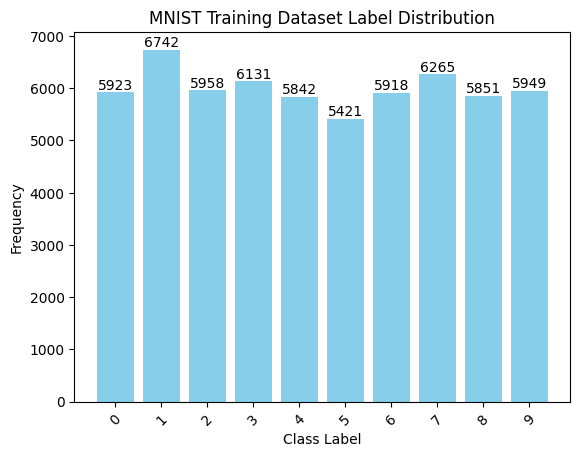

In [ ]:
# Load the MNIST dataset
mnist = load_dataset("mnist")

# Construct histogram for training labels
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values(), color="skyblue")
_ = plt.bar_label(bar)

# Plot formatting
plt.xticks(range(10), labels=[str(i) for i in range(10)], rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("MNIST Training Dataset Label Distribution")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One Partition has 600 examples.
One Partition has 480 examples.
Entropy: 3.3129
Max Entropy (Uniform Distribution): 3.3219
Distribution Uniformity Ratio: 0.9973


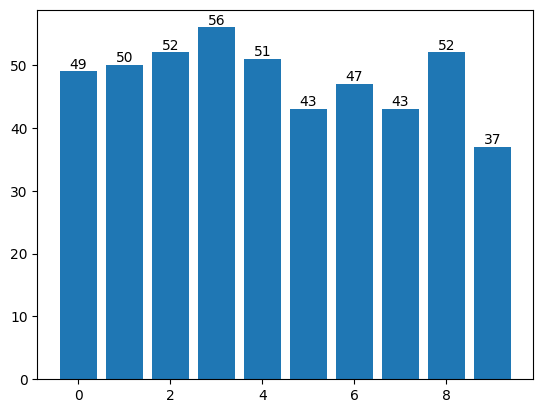

In [ ]:
num_partitions = 100  # Total number of participants
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": num_partitions}
)

partition = fds.load_partition(0)
print(f"One Partition has {len(partition)} examples.")

# Divider : 80% train, 20% test
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
train_size = len(partition_train_test["train"])
print(f"One Partition has {train_size} examples.")

all_labels = partition_train_test["train"]["label"]

label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
_ = plt.bar_label(bar)

total_count = sum(label_counts.values())

# Calculate proportions
proportions = [count / total_count for count in label_counts.values()]

# Calculate entropy
entropy = -sum(p * np.log2(p) for p in proportions)
max_entropy = np.log2(len(label_counts))  # Maximum entropy for uniform distribution

print(f"Entropy: {entropy:.4f}")
print(f"Max Entropy (Uniform Distribution): {max_entropy:.4f}")
print(f"Distribution Uniformity Ratio: {entropy / max_entropy:.4f}")

so the data is IID

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


# Train Test func


In [ ]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## set-get params


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## FlowerClient

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)
#============================================================================================
        # model_filename = f"federated_model_{server_round}.pth"
        # torch.save(net.state_dict(), model_filename)
        # print(f"Model saved as {model_filename}")
#============================================================================================
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)



        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [ ]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    return loss, {"server_round": server_round, "accuracy": accuracy, "loss": loss}

In [ ]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    model_filename = f"federated_model_{server_round}.pth"
    torch.save(net.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 ,
    }
    return config

In [ ]:
NUM_CLIENTS = 100

In [ ]:
NUM_ROUNDS = 40

In [ ]:
params = get_parameters(Net())

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=40, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07206681251525879, {'accuracy': 0.1418}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07206681251525879 / accuracy 0.1418
Model saved as federated_model_0.pth


(pid=2235) 2024-12-11 07:11:03.862374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2235) 2024-12-11 07:11:03.902926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2235) 2024-12-11 07:11:03.920532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=2235) 2024-12-11 07:11:06.199915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=2235) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2

(ClientAppActor pid=2235) [Client 54, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 50, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2235) [Client 61, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 44, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 48, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 27, round 1] fit, config: {'serve

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (1, 0.07129738645553589, {'accuracy': 0.2211}, 163.28518974399998)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07129738645553589 / accuracy 0.2211
Model saved as federated_model_1.pth
(ClientAppActor pid=2236) [Client 11] evaluate, config: {}
(ClientAppActor pid=2236) [Client 51, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 59] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 45] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 67] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 56] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 62] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 80] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 50] evaluate, config: {} [repeated 5x across cluster]
(Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.22250000000000003 0.0 
(ClientAppActor pid=2235) [Client 35, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 91] evaluate, config: {}
(ClientAppActor pid=2235) [Client 88, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 14, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 80, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 44, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 97, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Cl

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (2, 0.07025489642620086, {'accuracy': 0.3212}, 412.378351979)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07025489642620086 / accuracy 0.3212
Model saved as federated_model_2.pth
(ClientAppActor pid=2235) [Client 16] evaluate, config: {}
(ClientAppActor pid=2235) [Client 6] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 48] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 55] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 19] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 59] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 89] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 64] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 47] evaluate, 

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.3147499999999999 0.0 
(ClientAppActor pid=2236) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 56] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 24, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 87, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 94, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 18, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 30, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(C

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (3, 0.06784218099117278, {'accuracy': 0.3914}, 667.4299828640001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.06784218099117278 / accuracy 0.3914
Model saved as federated_model_3.pth
(ClientAppActor pid=2236) [Client 16] evaluate, config: {}
(ClientAppActor pid=2236) [Client 70, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 96] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 22] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 10] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 50] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 30] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 51] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 44] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 20] evaluate, config: {} [repeated 6x across cluster]
(Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.3858333333333334 0.0 
(ClientAppActor pid=2236) [Client 52, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 97] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 96, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 93, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 62, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 36, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 29, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 72, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (4, 0.05970849828720093, {'accuracy': 0.6026}, 914.7792240809999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.05970849828720093 / accuracy 0.6026
Model saved as federated_model_4.pth
(ClientAppActor pid=2236) [Client 45] evaluate, config: {}
(ClientAppActor pid=2235) [Client 32, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 69] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 23] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 56] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 46] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 84] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 48] evaluate, config: {} [repeated 5x across cluster]
(Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.5985833333333334 0.0 
(ClientAppActor pid=2235) [Client 40, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 59] evaluate, config: {}
(ClientAppActor pid=2236) [Client 85, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 91, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 28, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 55, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Clie

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (5, 0.03320473953485489, {'accuracy': 0.7606}, 1162.379502258)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.03320473953485489 / accuracy 0.7606
Model saved as federated_model_5.pth
(ClientAppActor pid=2236) [Client 0] evaluate, config: {}
(ClientAppActor pid=2236) [Client 73, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 99] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 67] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 87] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 53] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 72] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 83] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 32] evaluate, config: {} [repeated 6x across cluster]
(Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.7464166666666671 0.0 
(ClientAppActor pid=2235) [Client 19, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 11] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 80, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 64, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 96, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 46, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 95, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 34, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 3x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (6, 0.020448240473866463, {'accuracy': 0.8259}, 1404.841912276)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.020448240473866463 / accuracy 0.8259
Model saved as federated_model_6.pth
(ClientAppActor pid=2235) [Client 12] evaluate, config: {}
(ClientAppActor pid=2236) [Client 29, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 67] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 92] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 59] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 27] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 90] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 96] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 73] evaluate, config: {} [repeated 6x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8111666666666665 0.0 
(ClientAppActor pid=2235) [Client 41, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 61] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 80, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 45, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 37, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 43, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 13, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 3x across cluster]
(

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (7, 0.015320988066494465, {'accuracy': 0.8674}, 1654.5873867999999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.015320988066494465 / accuracy 0.8674
Model saved as federated_model_7.pth
(ClientAppActor pid=2236) [Client 31] evaluate, config: {}
(ClientAppActor pid=2236) [Client 38, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 47] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 65] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 96] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 73] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 45] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 7] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 34] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 88

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8562499999999997 0.0 
(ClientAppActor pid=2235) [Client 26, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 27] evaluate, config: {}
(ClientAppActor pid=2235) [Client 86, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 28, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 81, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 65, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 55, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 31, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Cl

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (8, 0.012850289238989353, {'accuracy': 0.8865}, 1900.2320324809998)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.012850289238989353 / accuracy 0.8865
Model saved as federated_model_8.pth
(ClientAppActor pid=2236) [Client 11] evaluate, config: {}
(ClientAppActor pid=2236) [Client 22, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 87] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 10] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 90] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 97] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 43] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 51] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 64] evaluate, config: {} [repeated 6x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8749999999999999 0.0 
(ClientAppActor pid=2235) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 22] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2236) [Client 97, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 61, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 87, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 95, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 5x across cluster]
(Cl

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (9, 0.011119216459989548, {'accuracy': 0.9019}, 2145.194916343)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.011119216459989548 / accuracy 0.9019
Model saved as federated_model_9.pth
(ClientAppActor pid=2235) [Client 38] evaluate, config: {}
(ClientAppActor pid=2236) [Client 47, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 37] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 93] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 61] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 86] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 49] evaluate, config: {} [repeated 6x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8894166666666666 0.0 
(ClientAppActor pid=2235) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 78] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 83, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 87, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 56, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 90, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 13, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 5x acro

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (10, 0.009982640435546636, {'accuracy': 0.9098}, 2394.676554332)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.009982640435546636 / accuracy 0.9098
Model saved as federated_model_10.pth
(ClientAppActor pid=2235) [Client 14] evaluate, config: {}
(ClientAppActor pid=2235) [Client 35, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 95] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 17] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 48] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 73] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 10] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 80] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 29] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8967499999999999 0.0 
(ClientAppActor pid=2235) [Client 8, round 11] fit, config: {'server_round': 11, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 67] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 77, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 33, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 51, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 46, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 44, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 42, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 4x acr

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (11, 0.00905368708819151, {'accuracy': 0.9187}, 2659.918261231)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.00905368708819151 / accuracy 0.9187
Model saved as federated_model_11.pth
(ClientAppActor pid=2236) [Client 8] evaluate, config: {}
(ClientAppActor pid=2236) [Client 85, round 11] fit, config: {'server_round': 11, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2236) [Client 31] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 72] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 85] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 67] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 98] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 70] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 76] evaluate, config: {} [repeated 5x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9069166666666665 0.0 
(ClientAppActor pid=2235) [Client 17, round 12] fit, config: {'server_round': 12, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 46] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 70, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 90, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 95, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 76, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 48, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 20, round 12] fit, config: {'server_round': 12, 'local_epochs': 1} [repeated 4x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (12, 0.00826458807438612, {'accuracy': 0.9235}, 2918.142444399)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.00826458807438612 / accuracy 0.9235
Model saved as federated_model_12.pth
(ClientAppActor pid=2235) [Client 49] evaluate, config: {}
(ClientAppActor pid=2236) [Client 77] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 79] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 15] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 21] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 34] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 0] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 38] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 91] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 76] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 14] evaluate

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9136666666666668 0.0 
(ClientAppActor pid=2235) [Client 51, round 13] fit, config: {'server_round': 13, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 95] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 93, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 79, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 22, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 73, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 15, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 44, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 4x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (13, 0.007756397356465459, {'accuracy': 0.93}, 3168.803868134)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.007756397356465459 / accuracy 0.93
Model saved as federated_model_13.pth
(ClientAppActor pid=2235) [Client 20] evaluate, config: {}
(ClientAppActor pid=2236) [Client 27, round 13] fit, config: {'server_round': 13, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 89] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 62] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 96] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 45] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 49] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 91] evaluate, config: {} [repeated 6x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.91775 0.0 
(ClientAppActor pid=2235) [Client 39, round 14] fit, config: {'server_round': 14, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 67] evaluate, config: {}
(ClientAppActor pid=2236) [Client 80, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 15, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 25, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 14, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 31, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 9, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (14, 0.007143841458112001, {'accuracy': 0.9345}, 3412.458533914)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.007143841458112001 / accuracy 0.9345
Model saved as federated_model_14.pth
(ClientAppActor pid=2236) [Client 2] evaluate, config: {}
(ClientAppActor pid=2236) [Client 32, round 14] fit, config: {'server_round': 14, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2236) [Client 59] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 93] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 35] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 70] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 86] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 67] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9235833333333339 0.0 
(ClientAppActor pid=2236) [Client 13, round 15] fit, config: {'server_round': 15, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 34] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2236) [Client 75, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 65, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 27, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 80, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 84, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 92, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 3x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (15, 0.006729367782175541, {'accuracy': 0.9369}, 3659.686279385)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.006729367782175541 / accuracy 0.9369
Model saved as federated_model_15.pth
(ClientAppActor pid=2236) [Client 21] evaluate, config: {}
(ClientAppActor pid=2235) [Client 17, round 15] fit, config: {'server_round': 15, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2236) [Client 28] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 67] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 41] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 26] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 13] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 58] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9282499999999996 0.0 
(ClientAppActor pid=2236) [Client 19, round 16] fit, config: {'server_round': 16, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 82] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 80, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 88, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 44, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 47, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 85, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 46, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 4x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (16, 0.0062969184771180155, {'accuracy': 0.9405}, 3903.776735252)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0062969184771180155 / accuracy 0.9405
Model saved as federated_model_16.pth
(ClientAppActor pid=2235) [Client 5] evaluate, config: {}
(ClientAppActor pid=2236) [Client 28, round 16] fit, config: {'server_round': 16, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 95] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 51] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 86] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 82] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 61] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 26] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9304999999999997 0.0 
(ClientAppActor pid=2235) [Client 10, round 17] fit, config: {'server_round': 17, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 98] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 58, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 64, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 40, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 65, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 93, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 85, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 5x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (17, 0.005985307947546243, {'accuracy': 0.9437}, 4151.985618796)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005985307947546243 / accuracy 0.9437
Model saved as federated_model_17.pth
(ClientAppActor pid=2235) [Client 50] evaluate, config: {}
(ClientAppActor pid=2236) [Client 94, round 17] fit, config: {'server_round': 17, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 78] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 45] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 85] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 38] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 33] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 25] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 98] evaluate, config: {} [repeated 5x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9344166666666665 0.0 
(ClientAppActor pid=2236) [Client 55, round 18] fit, config: {'server_round': 18, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 19] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 98, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 13, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 72, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 91, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 19, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 68, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 5x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (18, 0.005644888673909008, {'accuracy': 0.946}, 4397.590828904001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005644888673909008 / accuracy 0.946
Model saved as federated_model_18.pth
(ClientAppActor pid=2235) [Client 10] evaluate, config: {}
(ClientAppActor pid=2236) [Client 46, round 18] fit, config: {'server_round': 18, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 31] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 54] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 93] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 84] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 61] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 64] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 74] evaluate, config: {} [repeated 5x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=2236) [Client 12] evaluate, config: {} [repeated 6x across cluster]
My_weighted_average -0.9360000000000003 0.0 
(ClientAppActor pid=2235) [Client 39, round 19] fit, config: {'server_round': 19, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 49, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 3, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 34, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 8, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 87, round 19] fit, config: {'server_round': 19, 'local_epochs': 1} [repeated 4x acros

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (19, 0.005372153172083199, {'accuracy': 0.9483}, 4647.79765957)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005372153172083199 / accuracy 0.9483
Model saved as federated_model_19.pth
(ClientAppActor pid=2235) [Client 6] evaluate, config: {}
(ClientAppActor pid=2235) [Client 74] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 22] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 64] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 17] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 52] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 77] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 63] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 43] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 3] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 61] evaluate

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9388333333333329 0.0 
(ClientAppActor pid=2236) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 88] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 77, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 39, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 24, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 75, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 87, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 38, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 5x acr

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (20, 0.005189913877658546, {'accuracy': 0.9494}, 4894.512554208)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005189913877658546 / accuracy 0.9494
Model saved as federated_model_20.pth
(ClientAppActor pid=2235) [Client 9] evaluate, config: {}
(ClientAppActor pid=2235) [Client 66, round 20] fit, config: {'server_round': 20, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2236) [Client 92] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 66] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 99] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 94] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 48] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 74] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 26] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=2235) [Client 29] evaluate, config: {} [repeated 5x across cluster]
My_weighted_average -0.9412500000000001 0.0 
(ClientAppActor pid=2235) [Client 12, round 21] fit, config: {'server_round': 21, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 67, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 54, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 30, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 3, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 8, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 34, round 21] fit, config: {'server_round': 21, 'local_epochs': 1} [repeated 4x acro

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (21, 0.005013238011859357, {'accuracy': 0.9503}, 5139.566960517001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.005013238011859357 / accuracy 0.9503
Model saved as federated_model_21.pth
(ClientAppActor pid=2235) [Client 33] evaluate, config: {}
(ClientAppActor pid=2236) [Client 47] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 28] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 88] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 26] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 81] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 22] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 66] evaluate,

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9431666666666664 0.0 
(ClientAppActor pid=2235) [Client 25, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 55] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 71, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 41, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 74, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 43, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 99, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 57, round 22] fit, config: {'server_round': 22, 'local_epochs': 1} [repeated 3x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (22, 0.0048317260986194014, {'accuracy': 0.9521}, 5381.384664888001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0048317260986194014 / accuracy 0.9521
Model saved as federated_model_22.pth
(ClientAppActor pid=2235) [Client 49] evaluate, config: {}
(ClientAppActor pid=2236) [Client 84, round 22] fit, config: {'server_round': 22, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 97] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 26] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 79] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 81] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 98] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 11] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 85] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 33] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Cli

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9446666666666667 0.0 
(ClientAppActor pid=2235) [Client 6, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 12] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 97, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 93, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 52, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 11, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 48, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 71, round 23] fit, config: {'server_round': 23, 'local_epochs': 1} [repeated 4x acr

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (23, 0.004621782439015806, {'accuracy': 0.9536}, 5626.276206186)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004621782439015806 / accuracy 0.9536
Model saved as federated_model_23.pth
(ClientAppActor pid=2235) [Client 36] evaluate, config: {}
(ClientAppActor pid=2236) [Client 15, round 23] fit, config: {'server_round': 23, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 68] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 82] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 65] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 22] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 13] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 11] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 33] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9473333333333336 0.0 
(ClientAppActor pid=2235) [Client 0, round 24] fit, config: {'server_round': 24, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 95] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 97, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 19, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 15, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 13, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 59, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 68, round 24] fit, config: {'server_round': 24, 'local_epochs': 1} [repeated 5x acr

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (24, 0.00448539691157639, {'accuracy': 0.9552}, 5874.411258062)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.00448539691157639 / accuracy 0.9552
Model saved as federated_model_24.pth
(ClientAppActor pid=2235) [Client 47] evaluate, config: {}
(ClientAppActor pid=2235) [Client 30] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 38] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 87] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 40] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 73] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 25] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 56] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 67] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 71] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 65] evaluat

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9488333333333333 0.0 
(ClientAppActor pid=2236) [Client 35, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 35] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2235) [Client 82, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 51, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 5, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 32, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 84, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 43, round 25] fit, config: {'server_round': 25, 'local_epochs': 1} [repeated 4x acr

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (25, 0.004242128577735275, {'accuracy': 0.9596}, 6118.236960220001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004242128577735275 / accuracy 0.9596
Model saved as federated_model_25.pth
(ClientAppActor pid=2236) [Client 51] evaluate, config: {}
(ClientAppActor pid=2236) [Client 44, round 25] fit, config: {'server_round': 25, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 90] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 85] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 2] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 64] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 87] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 12] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 88] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 24] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Clien

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9528333333333336 0.0 
(ClientAppActor pid=2236) [Client 27, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=2236) [Client 30] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 50, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 37, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 64, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 94, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 55, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 82, round 26] fit, config: {'server_round': 26, 'local_epochs': 1} [repeated 4x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (26, 0.004121528528351337, {'accuracy': 0.9595}, 6360.123391035)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.004121528528351337 / accuracy 0.9595
Model saved as federated_model_26.pth
(ClientAppActor pid=2236) [Client 12] evaluate, config: {}
(ClientAppActor pid=2236) [Client 5, round 26] fit, config: {'server_round': 26, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 91] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 23] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 7] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 79] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 20] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 34] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 96] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 98] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.954 0.0 
(ClientAppActor pid=2235) [Client 3, round 27] fit, config: {'server_round': 27, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 90] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 90, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 12, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 71, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 87, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2236) [Client 51, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 26, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 5x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (27, 0.0040264733782038094, {'accuracy': 0.9604}, 6605.761623415)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.0040264733782038094 / accuracy 0.9604
Model saved as federated_model_27.pth
(ClientAppActor pid=2235) [Client 47] evaluate, config: {}
(ClientAppActor pid=2236) [Client 93, round 27] fit, config: {'server_round': 27, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=2235) [Client 76] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 34] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 25] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 17] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 4] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 84] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 11] evaluate, config: {} [repeated 6x across cluster]
(C

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.9550833333333334 0.0 
(ClientAppActor pid=2236) [Client 14, round 28] fit, config: {'server_round': 28, 'local_epochs': 1}
(ClientAppActor pid=2235) [Client 59] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 80, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 88, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 58, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2235) [Client 61, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=2236) [Client 13, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 5x across cluster]
(ClientAppActor pid=2235) [Client 90, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 5x ac

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (28, 0.003905576423089951, {'accuracy': 0.9615}, 6852.130425519001)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.003905576423089951 / accuracy 0.9615
Model saved as federated_model_28.pth
(ClientAppActor pid=2235) [Client 27] evaluate, config: {}
(ClientAppActor pid=2236) [Client 42, round 28] fit, config: {'server_round': 28, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=2236) [Client 13] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 74] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 5] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2236) [Client 20] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2235) [Client 91] evaluate, config: {}


(ClientAppActor pid=2236) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2236) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=2236) see the appropriate new directories, set the environment variable
(ClientAppActor pid=2236) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=2236) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=2236)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


KeyboardInterrupt: 

# plots

In [ ]:
net.load_state_dict(torch.load("federated_model_3.pth"))
net.eval()
_, valloader, _ = load_datasets(0, 1)
loss, accuracy = test(net, valloader)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

<ipython-input-28-ee3b8fdb1208>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("federated_model_3.pth"))


Validation Loss: 0.0679
Validation Accuracy: 0.38%


In [ ]:
Agregation_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'loss': 0.0, 'accuracy': 0.22250000000000003},
 {'loss': 0.0, 'accuracy': 0.3147499999999999},
 {'loss': 0.0, 'accuracy': 0.3858333333333334},
 {'loss': 0.0, 'accuracy': 0.5985833333333334},
 {'loss': 0.0, 'accuracy': 0.7464166666666671},
 {'loss': 0.0, 'accuracy': 0.8111666666666665},
 {'loss': 0.0, 'accuracy': 0.8562499999999997},
 {'loss': 0.0, 'accuracy': 0.8749999999999999},
 {'loss': 0.0, 'accuracy': 0.8894166666666666},
 {'loss': 0.0, 'accuracy': 0.8967499999999999},
 {'loss': 0.0, 'accuracy': 0.9069166666666665},
 {'loss': 0.0, 'accuracy': 0.9136666666666668},
 {'loss': 0.0, 'accuracy': 0.91775},
 {'loss': 0.0, 'accuracy': 0.9235833333333339},
 {'loss': 0.0, 'accuracy': 0.9282499999999996},
 {'loss': 0.0, 'accuracy': 0.9304999999999997},
 {'loss': 0.0, 'accuracy': 0.9344166666666665},
 {'loss': 0.0, 'accuracy': 0.9360000000000003},
 {'loss': 0.0, 'accuracy': 0.9388333333333329},
 {'loss': 0.0, 'accuracy': 0.9412500000000001},
 {'loss': 0.0, 'accuracy': 0.9431666666666664},
 {

In [ ]:
evaluation_history

[{'round': 0, 'loss': 0.07206681251525879, 'accuracy': 0.1418},
 {'round': 1, 'loss': 0.07129738645553589, 'accuracy': 0.2211},
 {'round': 2, 'loss': 0.07025489642620086, 'accuracy': 0.3212},
 {'round': 3, 'loss': 0.06784218099117278, 'accuracy': 0.3914},
 {'round': 4, 'loss': 0.05970849828720093, 'accuracy': 0.6026},
 {'round': 5, 'loss': 0.03320473953485489, 'accuracy': 0.7606},
 {'round': 6, 'loss': 0.020448240473866463, 'accuracy': 0.8259},
 {'round': 7, 'loss': 0.015320988066494465, 'accuracy': 0.8674},
 {'round': 8, 'loss': 0.012850289238989353, 'accuracy': 0.8865},
 {'round': 9, 'loss': 0.011119216459989548, 'accuracy': 0.9019},
 {'round': 10, 'loss': 0.009982640435546636, 'accuracy': 0.9098},
 {'round': 11, 'loss': 0.00905368708819151, 'accuracy': 0.9187},
 {'round': 12, 'loss': 0.00826458807438612, 'accuracy': 0.9235},
 {'round': 13, 'loss': 0.007756397356465459, 'accuracy': 0.93},
 {'round': 14, 'loss': 0.007143841458112001, 'accuracy': 0.9345},
 {'round': 15, 'loss': 0.00672

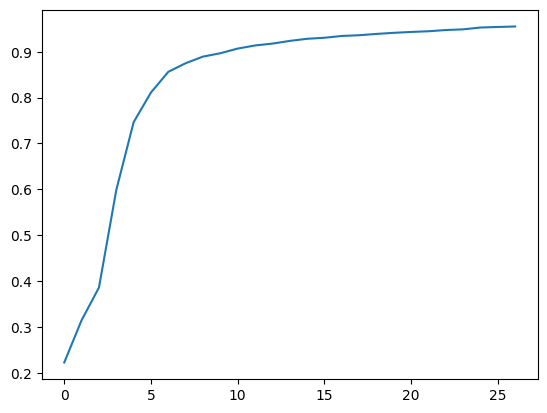

In [ ]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

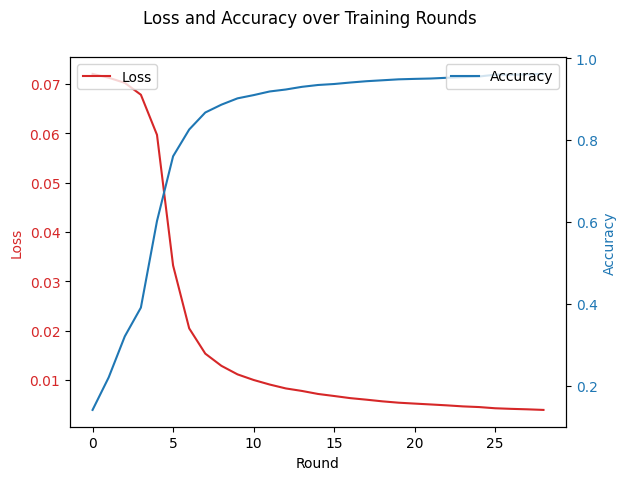

In [ ]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
